### **SOW-MKI49-2019-SEM1-V: NeurIPS**

# Project: Skeleton Code

In [11]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [12]:
class NeurosmashAgent:
    def __init__(self):
        pass

    def step(self, info, reward, state):
        # return 0 # no action
        # return 1 # left action
        # return 2 # right action
        # return 3 # built-in random action
        return 4 # built-in ai action

In [13]:
import random
import socket
import struct

class NeurosmashEnvironment:
    def __init__(self, ip = "127.0.0.1", port = 13000):
        self.client = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
        self.ip     = ip
        self.port   = port

        self.client.connect((ip, port))

    def init(self):
        self._send(0, 1)
        return self._receive()

    def step(self, action):
        self._send(action, 2)
        return self._receive()

    def _receive(self):
#         data   = [self.client.recv(1) for i in range(196610)]
        data   = self.client.recv(1 + 1 + 256 * 256 * 3, socket.MSG_WAITALL)
        info   = data[0]
        reward = data[1]

        state  = [data[i] for i in range(2, 196610)]
        return info, reward, state

    def _send(self, action, transition):
        self.client.send(bytes([action, transition]))

In [14]:
def state_to_screen(state, in01=True, norm=False):
    screen = np.reshape(state, (256, 256, 3), order='F').astype(np.uint8)
    if in01:
        screen = screen.astype(np.float64)
        screen /= 256
    screen = np.rot90(screen)
    rows,cols,ch = screen.shape

    bordersize = 17
    bordercolor = [0, 0, 0]

    screen = cv2.copyMakeBorder(
        screen,
        top=bordersize,
        bottom=bordersize,
        left=bordersize,
        right=bordersize,
        borderType=cv2.BORDER_CONSTANT,
        value=bordercolor
    )
    
    pts1 = [[144,44],[265,108],[128,256],[9,108]]
    pts2 = [[300,0],[260,265],[10,275],[20,28]]
    pts1 = np.float32(pts1)
    pts2 = np.float32(pts2)

    M = cv2.getPerspectiveTransform(pts1,pts2)

    screen = cv2.warpPerspective(screen,M,(300,300))
    screen = cv2.resize(screen, (256, 256))
    
    if norm:
        screen = normalize(screen)
    
    return screen

def normalize(picture, newmin=0, newmax=255):
#     dst = np.zeros(picture.shape)
#     return cv2.normalize(picture, dst=dst, alpha=newmin, beta=newmax, norm_type=cv2.NORM_INF)
    if len(picture.shape) == 2:
        oldmin = picture.min()
        oldmax = picture.max()
        out = (picture - oldmin) * (newmax - newmin) / (oldmax - oldmin) + newmin
    elif len(picture.shape) == 3:
        s = picture.sum(axis=2).reshape(256,256,1)
        s[s==0] = 1
        out = (picture / s * 255).astype(np.uint8)
    return out

def rgb2gray(img):
    dtype = img.dtype
    img = img.astype(np.float64)
    img[:,:,0] *= 0.4 #0.2989
    img[:,:,1] *= 0.35 #0.5870
    img[:,:,2] *= 0.25 #0.1140
    return img.mean(axis=2).astype(dtype)

In [1566]:
agent       = NeurosmashAgent()
environment = NeurosmashEnvironment()

In [1567]:
info, reward, state = environment.init()
print(info, reward)

KeyboardInterrupt: 

In [ ]:
# plt.ion()
screen_saver = []
done = False
while not done:
    action = agent.step(info, reward, state)
    info, reward, state = environment.step(action)
    screen_saver.append(state_to_screen(state))
    done = info == 1
#     screen = state_to_screen(state)
#     plt.imshow(screen)
#     plt.draw()
#     plt.pause(0.0001)
#     plt.clf()
    if reward != 1 or info != 0:
        print(f"Reward {reward}, info {info}")

In [1539]:
environment.step(4)[0]

1

In [86]:
# fig, ax = plt.subplots(len(screen_saver)-1, 1)
for i in range(1, len(screen_saver)):
    screen = screen_saver[i]
    prev_screen = screen_saver[i-1]
    
    diff = screen - prev_screen
#     ax[i-1].imshow(diff)

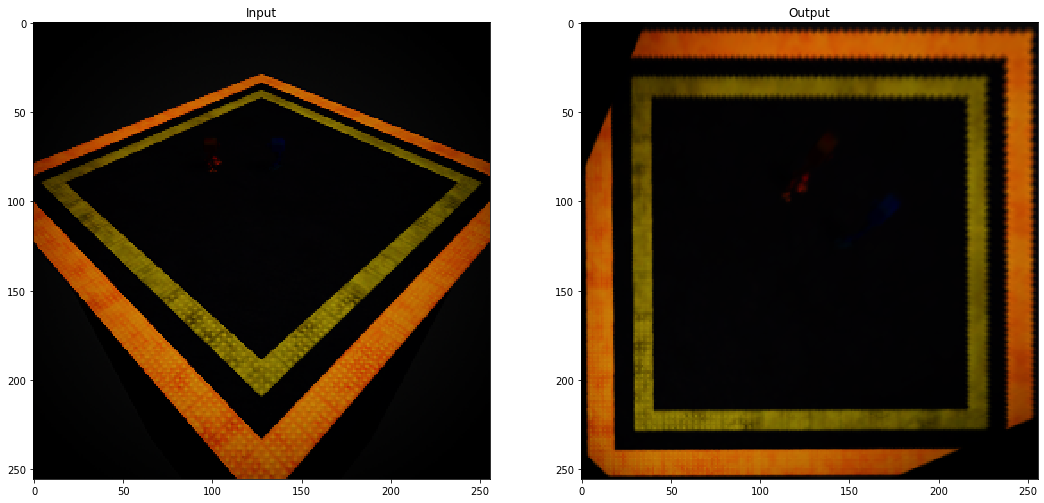

In [8]:
state_input = np.reshape(state, (256, 256, 3), order='F').astype(np.float64)/256
# state_input /= np.max(state_input, axis=(0, 1))
state_input = np.rot90(state_input)

screen = state_to_screen(state)

plt.subplots(2, figsize=(18, 30))
plt.subplot(121),plt.imshow(state_input),plt.title('Input')
plt.subplot(122),plt.imshow(screen),plt.title('Output')
plt.show()

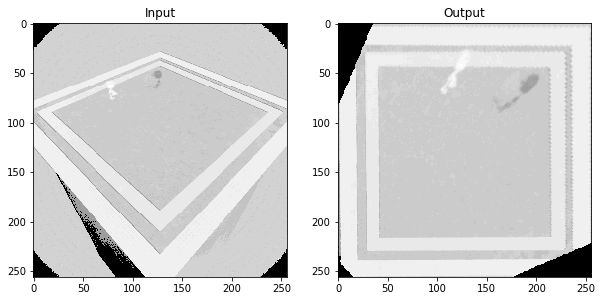

In [106]:
state_input = np.reshape(state, (256, 256, 3), order='F').astype(np.float64) / 256

state_input = np.rot90(state_input)
screen = state_to_screen(state)

state_input = normalize(state_input, 0, 255)
state_input = rgb2gray(state_input)
screen = normalize(screen, 0, 255)
screen = rgb2gray(screen)

fig, ax = plt.subplots(1, 2, figsize=(10, 20))
ax[0].imshow(state_input, cmap='gray')
ax[0].set_title('Input')
ax[1].imshow(screen, cmap='gray')
ax[1].set_title('Output')
plt.show()

Text(0.5, 1.0, 'diff')

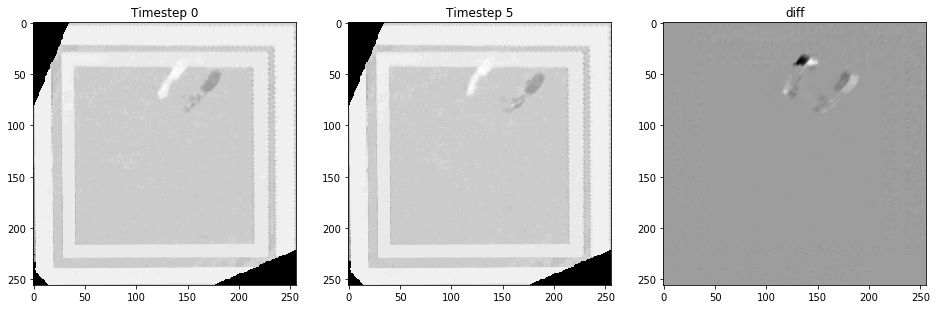

In [105]:
s1 = screen_saver[0]
s2 = screen_saver[5]
diff = s2 - s1

newmax = 1
newmin = 0
out = np.zeros(diff.shape)
for dim in range(diff.shape[-1]):
    pxs = diff[:,:,dim]
    oldmin = pxs.min()
    oldmax = pxs.max()
    out[:,:,dim] = (pxs - oldmin) * (newmax - newmin) / (oldmax - oldmin) + newmin

out = rgb2gray(out)
fig, ax = plt.subplots(1, 3, figsize=(16, 48))
ax[0].imshow(rgb2gray(normalize(s1)), cmap="gray")
ax[0].set_title("Timestep 0")
ax[1].imshow(rgb2gray(normalize(s2)), cmap="gray")
ax[1].set_title("Timestep 5")
ax[2].imshow(out, cmap="gray")
ax[2].set_title("diff")

In [1]:
import os
import time
from IPython import display

import tensorflow as tf
from tensorflow.keras import layers, optimizers, Sequential, Model

In [5]:
class CVAE(Model):
    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.inference_net = Sequential([
              layers.InputLayer(input_shape=(256, 256, 1)),
              layers.Conv2D(
                  filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
              layers.Conv2D(
                  filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
              layers.Flatten(),
              # No activation
              layers.Dense(latent_dim + latent_dim),
        ])

        self.generative_net = Sequential([
            layers.InputLayer(input_shape=(latent_dim,)),
            layers.Dense(units=7*7*32, activation=tf.nn.relu),
            layers.Reshape(target_shape=(7, 7, 32)),
            layers.Conv2DTranspose(
              filters=64,
              kernel_size=3,
              strides=(2, 2),
              padding="SAME",
              activation='relu'),
            layers.Conv2DTranspose(
              filters=32,
              kernel_size=3,
              strides=(2, 2),
              padding="SAME",
              activation='relu'),
            # No activation
            layers.Conv2DTranspose(
              filters=1, kernel_size=3, strides=(1, 1), padding="SAME"),
        ])

    
    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        mean, logvar = tf.split(self.inference_net(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z, apply_sigmoid=False):
        logits = self.generative_net(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

In [6]:
optimizer =  optimizers.Adam(1e-4)

def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)

@tf.function
def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)

    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

@tf.function
def compute_apply_gradients(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))


In [9]:
epochs = 100
latent_dim = 128
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

In [10]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model.sample(test_input)
    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

    # tight_layout minimizes the overlap between 2 sub-plots
#     plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()


In [ ]:
generate_and_save_images(model, 0, random_vector_for_generation)

for epoch in range(1, epochs + 1):
    start_time = time.time()
    for train_x in train_dataset:
        compute_apply_gradients(model, train_x, optimizer)
    end_time = time.time()

    if epoch % 1 == 0:
        loss = tf.keras.metrics.Mean()
        for test_x in test_dataset:
            loss(compute_loss(model, test_x))
        elbo = -loss.result()
        display.clear_output(wait=False)
        print('Epoch: {}, Test set ELBO: {}, '
              'time elapse for current epoch {}'.format(epoch,
                                                        elbo,
                                                        end_time - start_time))
#     generate_and_save_images(
#         model, epoch, random_vector_for_generation)
